In [1]:
import os
import sys
from pathlib import PurePath

# add custom python modules root to the path variable,
#root_path = PurePath(os.getcwd()).parents[2].joinpath('src')
#sys.path.insert(0, root_path)
root_path = "/home/jnmetz/tmp/src"
sys.path.append(root_path)

In [2]:
from importlib import reload
import pyspark.sql.functions as F
import pandas as pd
import numpy as np

import salesprediction.modelling.evaluation_metric as em
import salesprediction.modelling.client_usecase_aggregation as cua
import salesprediction.datapipeline.train_data_generation as tdg
import salesprediction.modelling.baseline_model as baseline_model
import salesprediction.modelling.xgboost_model as xgboost_model

## Modeling


In [3]:
# copied from data preparation step ---->

target_cell = "wash_de"  #Slow-moving, Homogeneous
#target_cell = "headset_fr"  #Many SKUs, Fast-moving
#target_cell = "ptv_ru"  #High revenue, Homogeneous
#target_cell = "hotbev_de"  #Heterogeneous
#target_cell = "cool_cn"  #revenue, Slow-moving, Homogeneous, Many SKUs
#target_cell = "printers_fr" #Few SKUs, Low revenue
granularity = "1m"
latest_start_date = "latest"

category = target_cell.split("_")[0]
country = target_cell.split("_")[1]
# copied <----

## Load and split data

In [4]:
# read from pickle
result_pdf = pd.read_pickle(category + "_" + country + "_result_pdf_features.pkl")
train_validation_data_pdf, test_data_pdf = tdg.train_test_split(result_pdf)

Min_date - max_date in input data:  2014-01-01 - 2020-03-01
Train periods:  2014-01-01 - 2019-02-01
Test periods:  2019-08-01 - 2019-10-01
Number of observations in full / train / test:  3283183 / 2679028 / 145520
Percentage of observations in train / test:  81.6 / 4.43
Percentage loss of observations:  13.97


## Train test split




In [6]:
train_validation_data_pdf, test_data_pdf = tdg.train_test_split(result_pdf)

Min_date - max_date in input data:  2014-01-01 - 2020-03-01
Train periods:  2014-01-01 - 2019-02-01
Test periods:  2019-08-01 - 2019-10-01
Number of observations in full / train / test:  3283183 / 2679028 / 145520
Percentage of observations in train / test:  81.6 / 4.43
Percentage loss of observations:  13.97


### Filter training data
* Keep only those item-outlet combinations where the item was at least 12 months on shelf within the training period


In [7]:
train_validation_data_filtered_pdf = train_validation_data_pdf[(train_validation_data_pdf['salesvalue_lc_lag_6'].notna()) 
                                                               & (train_validation_data_pdf['salesvalue_lc_lead_5'].notna())]

print(len(train_validation_data_pdf))
print(len(train_validation_data_filtered_pdf))

2679028
559584


### Filter test data
* Keep only those item-outlet combinations where the item was at least 12 months on shelf within the testing period

In [8]:
test_data_filtered_pdf = test_data_pdf[(test_data_pdf['salesvalue_lc_lag_6'].notna()) 
                                                               & (test_data_pdf['salesvalue_lc_lead_5'].notna())]
print(len(test_data_pdf))
print(len(test_data_filtered_pdf))

145520
29954


### What proportion of salesvalue in the test data are we losing due to this filtering condition? 

In [9]:
print("We only capture "  + 
      "{0:.0%}".format(test_data_filtered_pdf["target_next_6"].sum()/test_data_pdf["target_next_6"].sum()) +
                       " of the salesvalue in our prediction/evaluation due to the above filtering conditions")

We only capture 49% of the salesvalue in our prediction/evaluation due to the above filtering conditions


### Define features to be used in modeling 

In [10]:
# lagged variables
lagged_12_cols = ["salesvalue_lc" + "_lag_" + str(i) for i in range(1, 7)]

# seasonal dummies
seasonal_dummies = ["is_in_month_" + str(i).zfill(2) for i in range(1, 13)]

# rolling features
rolling_features =  ['salesvalue_lc_rmean_3',
                     'salesvalue_lc_rmean_6',
                     'salesvalue_lc_rmed_3',
                     'salesvalue_lc_rmed_6',
                     'salesvalue_lc_lag_3_ewm_0.9',
                     'salesvalue_lc_lag_6_ewm_0.9']


diverse_features = ["asp", "item_age", #"item_age_outlet_lvl",
                    "outlet_sales_in_category"]

# combination
features =  lagged_12_cols  + seasonal_dummies + rolling_features + diverse_features #+ trended_features


### Create train and test feature matrix

In [12]:
X_train = train_validation_data_filtered_pdf[features].values
y_train = train_validation_data_filtered_pdf["target_next_6"].values
X_test = test_data_filtered_pdf[features].values
y_test = test_data_filtered_pdf["target_next_6"].values

### Baseline model

In [14]:

test_data_filtered_pdf["baseline_prediction"] = baseline_model.predict(test_data_filtered_pdf)

/opt/cloudera/parcels/Anaconda-5.1.0.1/envs/newron-dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Fit xgboost model

In [17]:
xg_reg = xgboost_model.fit_model(X_train, X_test, y_train, y_test)

[0]	validation_0-rmse:73257.9	validation_1-rmse:74605.7
[1]	validation_0-rmse:70377	validation_1-rmse:72196.4
[2]	validation_0-rmse:67603	validation_1-rmse:69875.7
[3]	validation_0-rmse:65055.6	validation_1-rmse:67794.3
[4]	validation_0-rmse:62648	validation_1-rmse:65912.4
[5]	validation_0-rmse:60328.9	validation_1-rmse:63912.7
[6]	validation_0-rmse:58146.1	validation_1-rmse:62033.5
[7]	validation_0-rmse:56102.2	validation_1-rmse:60341.4
[8]	validation_0-rmse:54161.4	validation_1-rmse:58895.1
[9]	validation_0-rmse:52326.8	validation_1-rmse:57468.4
[10]	validation_0-rmse:50576.7	validation_1-rmse:56227.4
[11]	validation_0-rmse:48960.1	validation_1-rmse:54968.4
[12]	validation_0-rmse:47410.1	validation_1-rmse:53747
[13]	validation_0-rmse:45967.4	validation_1-rmse:52610.6
[14]	validation_0-rmse:44639.8	validation_1-rmse:51611.6
[15]	validation_0-rmse:43413.6	validation_1-rmse:50684.4
[16]	validation_0-rmse:42223.9	validation_1-rmse:49810.3
[17]	validation_0-rmse:41132.6	validation_1-rmse:

#### Inspect train vs. test set loss

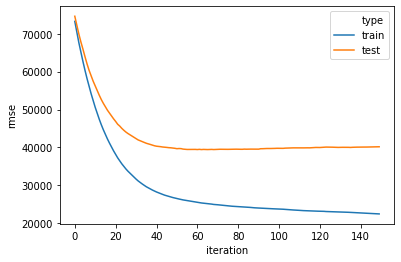

In [18]:
xgboost_model.xgb_train_vs_test_loss(xg_reg)

#### Inspect feature importances

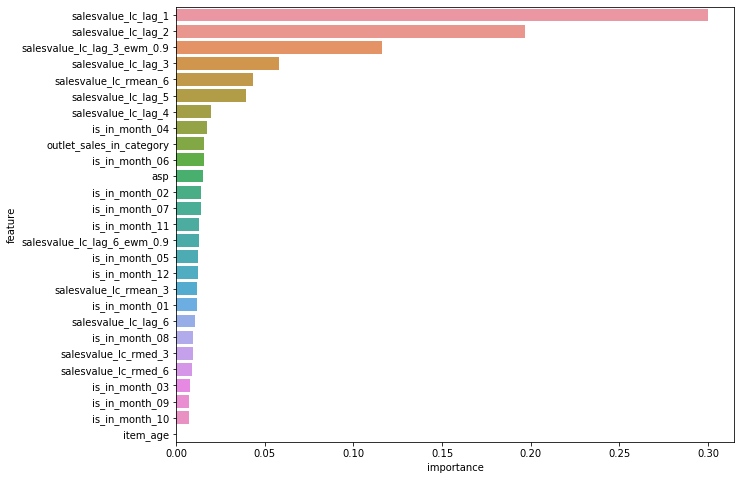

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
xgboost_model.xgb_feature_importances(xg_reg, features)

#### Predict

In [20]:
shop_channel = 'Technical Superstores'
shop_size = 'Medium'

#### Apply shop size & channel to only predict on the relevant stores

In [21]:
test_data_for_pred = test_data_filtered_pdf[(test_data_filtered_pdf['channel'] == shop_channel) & (test_data_filtered_pdf['shop_size'] == shop_size)]
X_test_for_pred = test_data_for_pred[features].values

In [22]:
test_data_for_pred["xgboost_prediction"] = xg_reg.predict(X_test_for_pred)

/opt/cloudera/parcels/Anaconda-5.1.0.1/envs/newron-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Aggregate the predictions

#### Create aggregated response variable to check against

In [23]:
aggregated_resp_var = cua.aggregate_resp_var(test_data_for_pred, response_var = 'target_next_6',
                       shop_size = shop_size, shop_channel = shop_channel)

#### Simply calculate mean prediction per item/channel/store size level

In [24]:
final_results = cua.aggregate_predictions_to_store_size_channel_item_level(test_data_for_pred)

In [25]:
# merge the results to the main table for validation
aggregated_resp_var = pd.merge(aggregated_resp_var, final_results, 
                              on = ['item_id', 'channel', 'shop_size', 'period_id'], how = 'left')

## Evaluation

#### Run MAPE

In [26]:
em.calculate_mape_metric_good_granularity(aggregated_resp_var, predicted_col = 'mean_xgboost_prediction',
                                          expected_col = 'target_next_6_aggregated')

27.39094643396561

## Loop over all channels & segments to check how well each one is doing in terms of MAPE

### Define threshold of 20 observations required per segment to make a prediction

In [27]:
MIN_OBSERVATIONS_TO_PREDICT = 20

In [28]:
all_channels = test_data_filtered_pdf['channel'].unique().tolist()
all_shop_sizes = test_data_filtered_pdf['shop_size'].unique().tolist()

In [29]:
shop_size_list = []
channel_list = []
main_xgboost_MAPE_list = []
segm_count = []

for shop_channel in all_channels:
    
    for shop_size in all_shop_sizes:
        
        shop_size_list.append(shop_size)
        channel_list.append(shop_channel)
        
        test_data_for_pred = test_data_filtered_pdf[(test_data_filtered_pdf['channel'] == shop_channel) & (test_data_filtered_pdf['shop_size'] == shop_size)]
        X_test_for_pred = test_data_for_pred[features].values
        
        segm_size = X_test_for_pred.shape[0]
        segm_count.append(segm_size)
        basic_printout = 'Number of observations for channel: %s, size: %s: %d' % (shop_channel, shop_size, segm_size)
        print(basic_printout)
        
        
        if segm_size < MIN_OBSERVATIONS_TO_PREDICT:
            print(basic_printout + " - too little observations to compute prediction")
            main_xgboost_MAPE_list.append(np.nan)            
            next
        else:
            try:
                print(basic_printout)
                test_data_for_pred["xgboost_prediction"] = xg_reg.predict(X_test_for_pred)

                aggregated_resp_var = cua.aggregate_resp_var(test_data_for_pred, response_var = 'target_next_6',
                           shop_size = shop_size , shop_channel = shop_channel)
                final_results = cua.aggregate_predictions_to_store_size_channel_item_level(test_data_for_pred)
                aggregated_resp_var = pd.merge(aggregated_resp_var, final_results, 
                                              on = ['item_id', 'channel', 'shop_size', 'period_id'], how = 'left')
                MAPE_mean_xgboost = em.calculate_mape_metric_good_granularity(aggregated_resp_var, predicted_col = 'mean_xgboost_prediction',
                                              expected_col = 'target_next_6_aggregated')
                main_xgboost_MAPE_list.append(MAPE_mean_xgboost)
                                   
            except Exception as e:
                print(e)

Number of observations for channel: Electrical Specialists, size: Medium: 317
Number of observations for channel: Electrical Specialists, size: Medium: 317
Number of observations for channel: Electrical Specialists, size: Small: 88
Number of observations for channel: Electrical Specialists, size: Small: 88
Number of observations for channel: Electrical Specialists, size: Large: 568
Number of observations for channel: Electrical Specialists, size: Large: 568


/opt/cloudera/parcels/Anaconda-5.1.0.1/envs/newron-dev/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of observations for channel: Technical Superstores, size: Medium: 5747
Number of observations for channel: Technical Superstores, size: Medium: 5747
Number of observations for channel: Technical Superstores, size: Small: 2146
Number of observations for channel: Technical Superstores, size: Small: 2146
Number of observations for channel: Technical Superstores, size: Large: 15862
Number of observations for channel: Technical Superstores, size: Large: 15862
Number of observations for channel: Hypermarkets, size: Medium: 683
Number of observations for channel: Hypermarkets, size: Medium: 683
Number of observations for channel: Hypermarkets, size: Small: 105
Number of observations for channel: Hypermarkets, size: Small: 105
Number of observations for channel: Hypermarkets, size: Large: 632
Number of observations for channel: Hypermarkets, size: Large: 632
Number of observations for channel: Cash&Carry, size: Medium: 552
Number of observations for channel: Cash&Carry, size: Medium: 55

In [30]:
# Summarize all into one dataframe

summarized_data = {
    'channel' : channel_list,
    'shop_size': shop_size_list,
    'nb_observations' : segm_count,
    'mean_xgboost_prediction_MAPE' : main_xgboost_MAPE_list
}
    
MAPE_per_segment = pd.DataFrame.from_dict(summarized_data)

In [31]:
MAPE_per_segment

,channel,shop_size,nb_observations,mean_xgboost_prediction_MAPE
0,Electrical Specialists,Medium,317,31.186441
1,Electrical Specialists,Small,88,29.137673
2,Electrical Specialists,Large,568,30.059825
3,Technical Superstores,Medium,5747,27.390946
4,Technical Superstores,Small,2146,28.450981
5,Technical Superstores,Large,15862,47.624387
6,Hypermarkets,Medium,683,30.382273
7,Hypermarkets,Small,105,32.983939
8,Hypermarkets,Large,632,56.592581
9,Cash&Carry,Medium,552,23.087534
